### Basic Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import torch
import torch.nn as nn
from astra.torch.models import MLPRegressor

import matplotlib.pyplot as plt
import numpy as np
# Retina mode
%config InlineBackend.figure_format = 'retina'

torch.Size([20, 1]) torch.Size([20, 1]) torch.Size([200, 1]) torch.Size([200, 1])


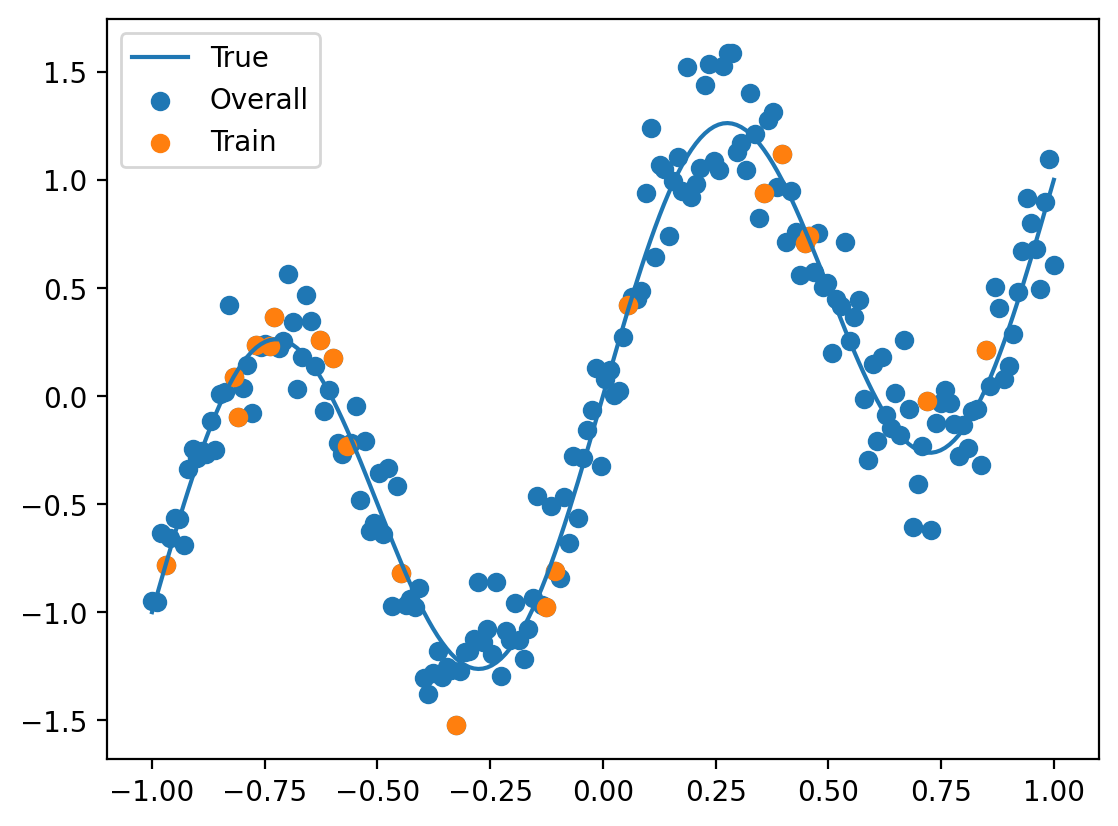

In [2]:
# Create training and test data
x_overall = torch.linspace(-1, 1, 200).reshape(-1, 1)
n_train = 20

f_true = lambda x: torch.sin(2 * np.pi * x) + x

noise = torch.distributions.Normal(0, 0.2)

y_true = f_true(x_overall) 
y_overall = y_true + noise.sample(x_overall.shape)

train_idx = torch.randperm(x_overall.shape[0])[:n_train]
x_train = x_overall[train_idx]
y_train = y_overall[train_idx]

plt.plot(x_overall, y_true, label='True')
plt.scatter(x_overall, y_overall, label='Overall')
plt.scatter(x_train, y_train, label='Train');
plt.legend();

print(x_train.shape, y_train.shape, x_overall.shape, y_overall.shape)

In [28]:
# Train the models for mean and covariance

mean_function = MLPRegressor(1, [10, 10, 10], 1).cuda()
cov_function = MLPRegressor(1, [10], 1).cuda()
log_noise_var = torch.tensor(-1.0, device="cuda", requires_grad=True)

params = list(mean_function.parameters()) + list(cov_function.parameters()) + [log_noise_var]

optimizer = torch.optim.Adam(params, lr=1e-2)

n_epochs = 2000

for i in range(n_epochs):
    mu = mean_function(x_train.cuda()).squeeze()
    L = cov_function(x_train.cuda())
    cov_nn = L @ L.T
    cov_nn.diagonal().add_(torch.exp(log_noise_var))

    mvn = torch.distributions.MultivariateNormal(mu, cov_nn)
    
    loss = -mvn.log_prob(y_train.squeeze().cuda()).mean()
    if i%200 == 0:
        print(i, loss.item())
    
    loss.backward()
    optimizer.step()
    
    optimizer.zero_grad()

0 22.6207275390625
200 -7.75834846496582
400 -15.416336059570312
600 -18.13788414001465
800 -19.777786254882812
1000 -17.020503997802734
1200 -21.192989349365234
1400 -21.867210388183594
1600 -20.04407501220703
1800 -23.807193756103516


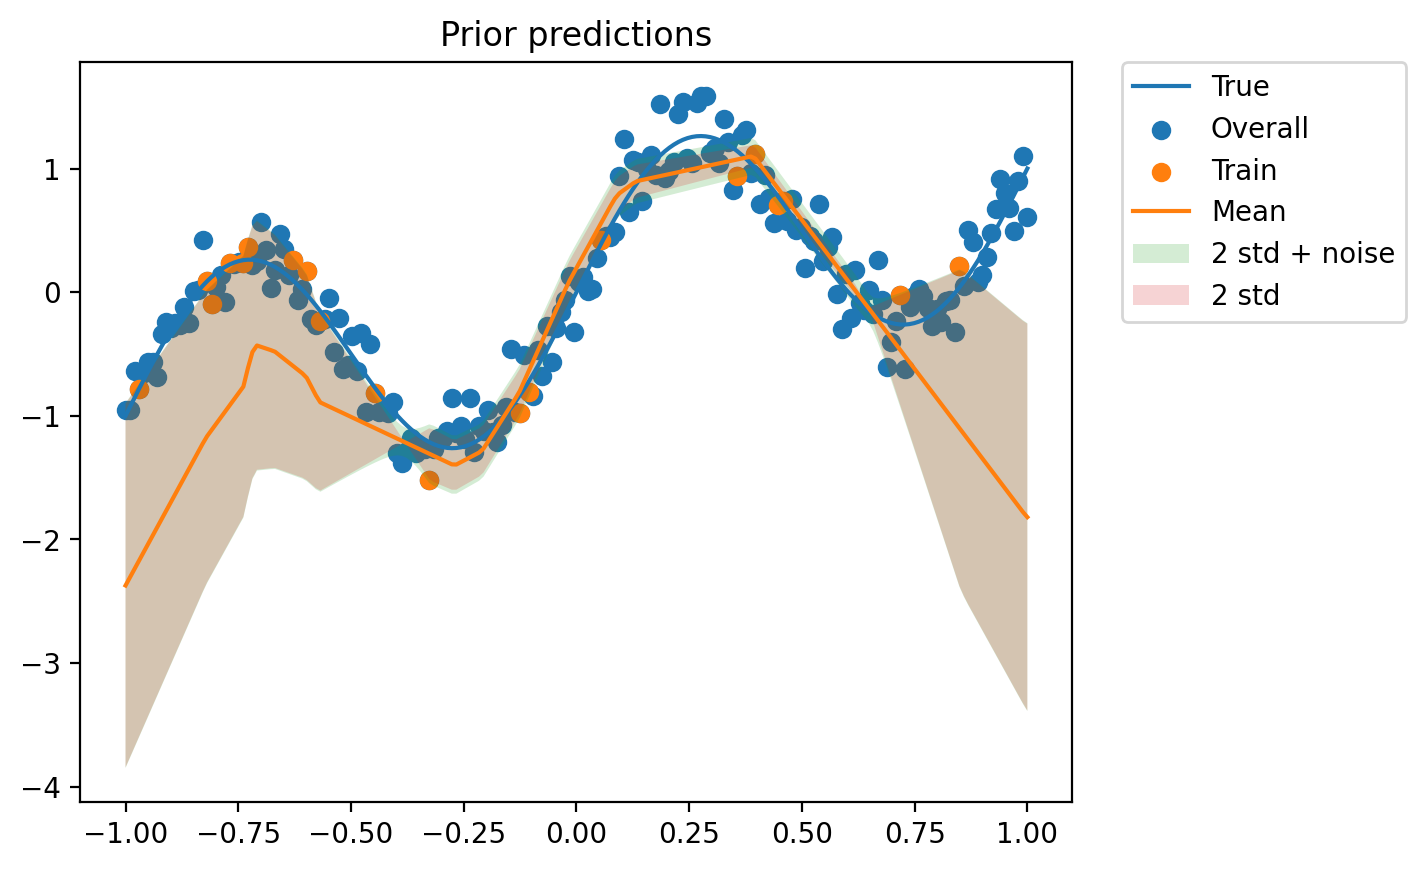

In [32]:
mean_function.cpu()
cov_function.cpu()
log_noise_var = log_noise_var.cpu()

plt.plot(x_overall, y_true, label='True')
plt.scatter(x_overall, y_overall, label='Overall')
plt.scatter(x_train, y_train, label='Train');
plt.plot(x_overall, mean_function(x_overall).squeeze().detach(), label='Mean')

with torch.no_grad():
    sigma = cov_function(x_overall).squeeze().detach()

    sigma_plus_noise = torch.sqrt(sigma**2 + torch.exp(log_noise_var))
    plt.fill_between(x_overall.squeeze(),
                        (mean_function(x_overall).squeeze() - 2 * sigma_plus_noise),
                        (mean_function(x_overall).squeeze() + 2 * sigma_plus_noise),
                        alpha=0.2, label='2 std + noise')

    plt.fill_between(x_overall.squeeze(),
                        (mean_function(x_overall).squeeze() - 2 * sigma),
                        (mean_function(x_overall).squeeze() + 2 * sigma),
                        alpha=0.2, label='2 std')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);
plt.title('Prior predictions');

torch.Size([200])


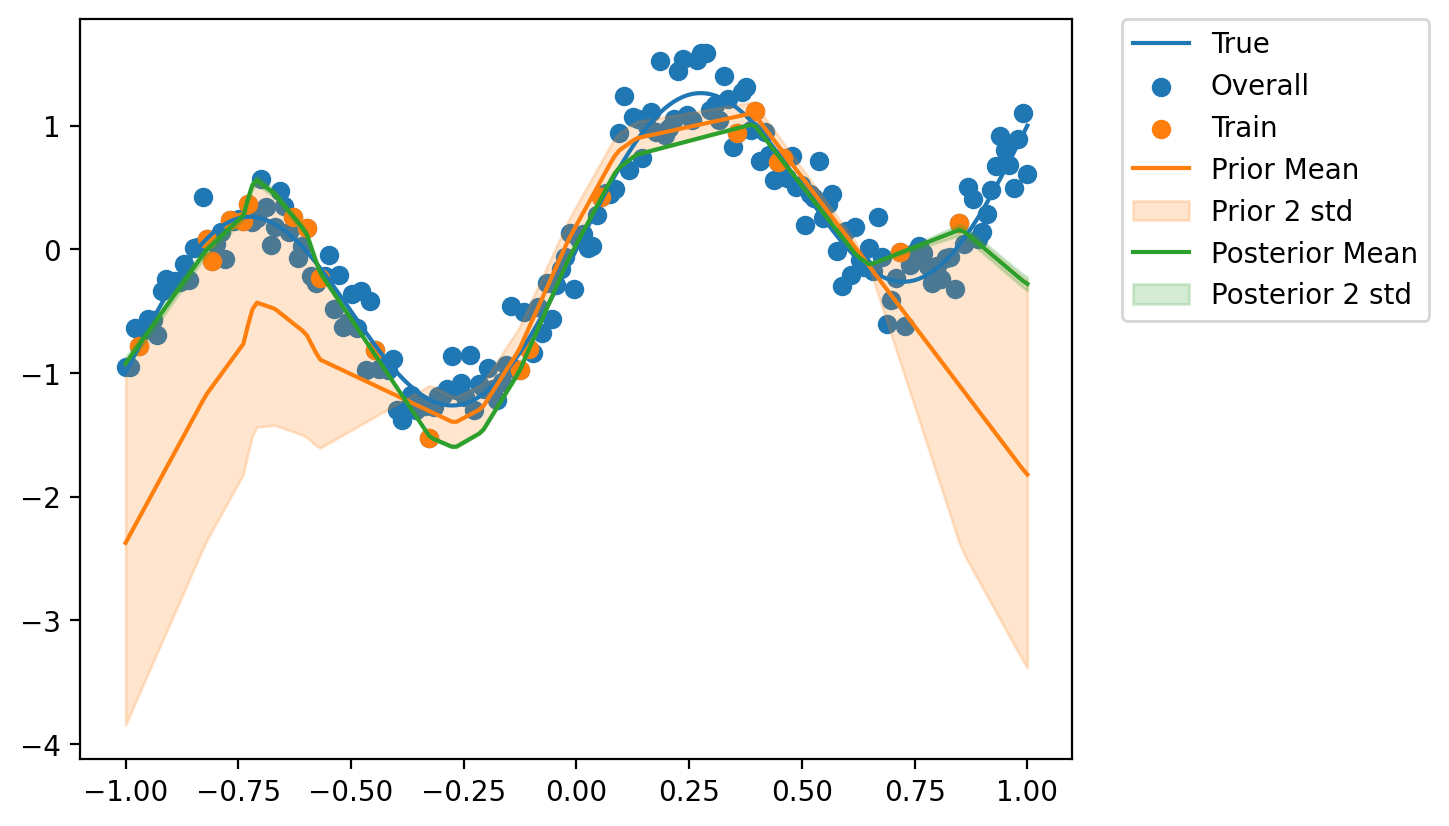

In [57]:
L_train = cov_function(x_train)
cov_train = L_train @ L_train.T
cov_train.diagonal().add_(torch.exp(log_noise_var))
chol = torch.linalg.cholesky(cov_train)
alpha = torch.cholesky_solve(y_train - mean_function(x_train), chol, upper=False)

cov_train_test = cov_function(x_overall) @ L_train.T

mean_posterior = mean_function(x_overall) + cov_train_test @ alpha
var_posterior = cov_function(x_overall).squeeze()**2 - (cov_train_test @ torch.cholesky_solve(cov_train_test.T, chol, upper=False)).diagonal()
sigma_posterior = torch.sqrt(var_posterior)
print(sigma_posterior.shape)

plt.plot(x_overall, y_true, label='True')
plt.scatter(x_overall, y_overall, label='Overall')
plt.scatter(x_train, y_train, label='Train');

with torch.no_grad():
    plt.plot(x_overall, mean_function(x_overall).squeeze().detach(), label='Prior Mean', color="C1")
    plt.fill_between(x_overall.squeeze(),
        (mean_function(x_overall).squeeze() - 2 * sigma),
        (mean_function(x_overall).squeeze() + 2 * sigma),
        alpha=0.2, label='Prior 2 std', color="C1")
    
    plt.plot(x_overall, mean_posterior.squeeze().detach(), label='Posterior Mean', color="C2")
    plt.fill_between(x_overall.squeeze(),
        (mean_posterior.squeeze() - 2 * sigma_posterior),
        (mean_posterior.squeeze() + 2 * sigma_posterior),
        alpha=0.2, label='Posterior 2 std', color="C2")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);